(adversarias-patch)=
# Adversarial Patch Detection

In this notebook we will be using the attack <i>Adversarial Patch</i> introduced in {cite}`brown2018adversarial`.

As in {ref}`fgsm` and {ref}`one-pixel` we will use PyTorch.

In [1]:
import os
import glob
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import *
from PIL import Image
import matplotlib.pyplot as plt

data_folder = os.path.join('data/')
# setting a random seed makes the random number generator deterministic and reproducible
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [2]:
# use compatible NVidia GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda found!')
else:
    device = torch.device('cpu')
    print('no cuda found')

no cuda found


## Loading the model

To be able to use this attack, first we need to select the machine learning model that we will use as an image classifier. For that purpose, we we will use the models available in the library torchvision, that is part of pytorch

These models have been pre-trained in 1000 categories from the image dataset [ImageNet](https://image-net.org/).

We can find the models available in torchvision in the [torchvision website](https://pytorch.org/vision/stable/index.html).

In [3]:
# we set the parameters pretrained and progress to True, to download the pretrained model with a progress bar
net = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)

# when we load a model with pytorch, by default it is in train mode
# as we are going to use the model to make predictions we set it with evaluation mode
# with the ; we hide the output that was going to be printed out 
net.eval(); 

# we pass the model to the device just with this one line of code
net.to(device);

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /Users/minha/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100.0%


We also need to load the labels associated to the categories used to train the model. In this case the categories are the 1000 used in the competition ImageNet Large Scale Visual Recognition Challenge. 

In the text file synset_words.txt you can see all the categories of images that the mode has been trained on. These categories, also known as *synsets*, were inheret from project [WordNet](https://wordnet.princeton.edu/)

They use several keywords to describe each category. In the file synset_words.txt, I abbreviated these keywords. You can find the original list in this link: https://gist.github.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372


In [4]:
with open(os.path.join(data_folder, 'synset_words.txt'), 'r') as f:
    synset_words = [' '.join(s.replace('\n', '').split(' ')[1:]) for s in f.readlines()]

np.random.choice(synset_words, 5)

array(['echidna, spiny anteater, anteater',
       'bathtub, bathing tub, bath, tub',
       'tobacco shop, tobacconist shop, tobacconist',
       'white wolf, Arctic wolf, Canis lupus tundrarum', 'wombat'],
      dtype='<U121')

## Loading and visualizing images

As previously, we need some pre-processing on our images before we can use them in the neural net.

But first, lets load a manipulated image.

In [5]:
images = {}
for file_name in glob.glob(os.path.join(data_folder, 'images', 'toaster-*.jpg')):
    # remove file extension and path
    short_file_name = os.path.splitext(os.path.split(file_name)[-1])[0]
    images[os.path.splitext(short_file_name)[0]] = {
        # Image is from PIL library
        'image': Image.open(file_name)
    }
    print(f"loaded {file_name}")

loaded data/images/toaster-resnet-1.jpg


In [6]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

preprocess_alexnet = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor(),
    Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


def plot_image(img_tensor: torch.tensor, dataset_mean: np.array = IMAGENET_MEAN, dataset_std: np.array = IMAGENET_STD) -> None:
    img_tensor = img_tensor.permute(1, 2, 0)
    img_np = img_tensor.detach().cpu().numpy()
    
    # _STD[None, None] adds 2 dimensions so we are multiplying the color dimension of the picture
    img_np = (img_np * dataset_std[None,None]) + dataset_mean[None,None]
    img_np = np.clip(img_np, a_min=0.0, a_max=1.0)
    
    # we plot the image 
    plt.figure()
    plt.axis('off')
    plt.imshow(img_np)

Once we load the image, we are going to conduct a pre-processing step.

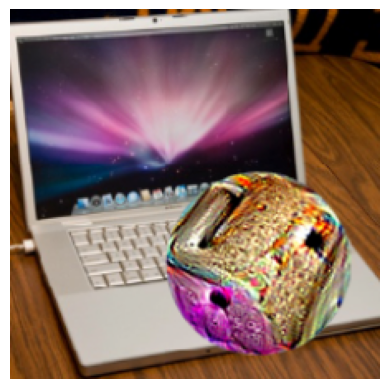

In [7]:
original_img_tensor = preprocess_alexnet(images['toaster-resnet-1']['image'])
plot_image(original_img_tensor)

## Using the model to predict the content of the image

Then with the function `predict_image_top_categories()` we use the model to predict the content in the image. This function returns the number of categories, defined by the parameter `num_top_cat`, with a higher probability predicted by the model.

In [8]:
def predict_image_top_categories(
    img_tensor: torch.tensor,
    model: torchvision.models,
    labels: List[str],
    device: torch.device,
    num_top_cat: int = 5
) -> List[List[str]]:
    # create a mini-batch as expected by the model
    # add an extra batch dimension since pytorch treats all images as batches
    input_batch = img_tensor.unsqueeze(0)
    
    # we send it to the device
    input_batch = input_batch.to(device)
    
    # forward pass, it returns unnormalized scores
    output = model(input_batch)

    # we use the Softmax function to get the probability distribution over categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()
    
    # show top categories per image
    top_prob, top_catid = torch.topk(probabilities, num_top_cat)
    return top_prob, top_catid

In [9]:
print('Prediction Original image:')
top_pred_conf, top_pred_idx =  predict_image_top_categories(original_img_tensor, net, synset_words, device, num_top_cat=5)

for conf, cat_id in zip(top_pred_conf, top_pred_idx):
    print(f'Confidence {conf:.2%}\t{cat_id}\t{synset_words[cat_id]}')

pred_conf = top_pred_conf[0] 
pred_idx = top_pred_idx[0] 
pred_label = synset_words[top_pred_idx[0]]

Prediction Original image:
Confidence 98.36%	859	toaster
Confidence 1.43%	626	lighter, light, igniter, ignitor
Confidence 0.10%	710	pencil sharpener
Confidence 0.03%	742	printer
Confidence 0.02%	673	mouse, computer mouse


/Users/minha/dev/tinova/adversarial-noise-workshop/.venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


We see that by placing a specific digital patch on the image we can trick the net to predict wrong.

The code to generate this patch can be seen [here](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/examples/adversarial_patch/AdversarialPatch.ipynb). The code needs some mantaining as it relies on old versions of dependencies.

## Patches in real life

The nice thing about these badges is that those patches do not only work on manipulated digital images but also as real life.
For this we want to take a look at it by placing those batches in the real world and taking a photo of it.

The interactive version relies on Google Colab - therefore the interactive part is omitted here and instead we will rely on a static image.
Feel free to replace this image with your own.

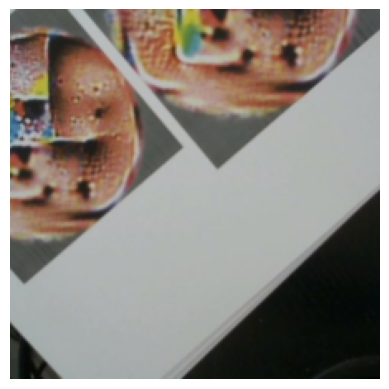

In [10]:
webcam_image_path = os.path.join(data_folder, 'images', 'webcam.jpg')

webcam_image = Image.open(webcam_image_path).convert('RGB')

img_tensor = preprocess_alexnet(webcam_image)

plot_image(img_tensor)

In [11]:
num_top_cat = 5
top_pred_conf, top_pred_idx =  predict_image_top_categories(
    img_tensor,
    net,
    synset_words,
    device,
    num_top_cat
)

for conf, cat_id in zip(top_pred_conf, top_pred_idx):
    print(f'Confidence {conf:.2%}\t{cat_id}\t{synset_words[cat_id]}')

Confidence 47.21%	61	boa constrictor, Constrictor constrictor
Confidence 32.68%	62	rock python, rock snake, Python sebae
Confidence 11.70%	60	night snake, Hypsiglena torquata
Confidence 1.74%	66	horned viper, cerastes, sand viper, horned asp, Cerastes cornutus
Confidence 1.08%	32	tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui


## References

For more applications in real life check out {cite}`wu2020making`, {cite}`xu2020adversarial` and {cite}`glasses`.

### Bibliography

```{bibliography}
:filter: docname in docnames
```